# Get graph embeddings from GraphSage output

In [69]:
%matplotlib notebook
import graph_tool
import snap
import numpy as np
from pymongo import MongoClient, GEOSPHERE
from matplotlib import pylab as plt
import operator
from IPython.display import HTML, display
import tabulate
from scipy import stats
import collections
from os import path
import json

In [70]:
# Database client

client = MongoClient('localhost', 27272)
db = client.test
business = db.business
reviews = db.review
users = db.users

In [71]:
top_cities = [u'Las Vegas',
 u'Phoenix',
 u'Toronto',
 u'Charlotte',
 u'Scottsdale',
 u'Calgary',
 u'Pittsburgh',
 u'Mesa',
 u'Montr\xe9al',
 u'Henderson']

dir_format = '/yagami/lyl/project/GraphSAGE/unsup-GraphSAGE_input/{}_graphsage_mean_small_0.000010'

## Get Graph Embeddings for each cascade graph

In [72]:
business_ids = list(db.city_business.find(
        {},
        {
            '_id': 0,
            'business_id': 1
        }
    ))

In [73]:
embedding_graph = {}

for i, business in enumerate(business_ids):
    business_id = business['business_id']
    dir_name = dir_format.format(business_id)
    val_npy_loc = path.join(dir_name, 'val.npy')
    if not path.exists(val_npy_loc):
        continue
    embedding_mat = np.load(val_npy_loc)
    
    embedding_avg = np.average(embedding_mat, axis=0)
    embedding_sum = np.sum(embedding_mat, axis=0)
    embedding = np.concatenate((embedding_avg, )) # embedding_sum
    embedding_graph[business_id] = embedding

In [74]:
len(embedding_graph)

9663

## Baseline business Feature

In [75]:
business_small_path = '../yelp/business_small.json'
business_path = '../yelp/yelp_academic_dataset_business.json'

In [76]:
def parse_business_feats(path):
    embed_graph = {}
    with open(path) as json_file:
        for line in json_file:
            raw = json.loads(line)
            bid = raw['business_id']
            feats = []
            for entity in ['stars', 'review_count', 'is_open', 'latitude', 'longitude']:
                tmp  = float(raw[entity]) if raw[entity] != None else 0.
                feats.append(tmp)
            embed_graph[bid] = np.array(feats) 
    return embed_graph
def business_id_list(path):
    id_list = []
    i = 0
    with open(path, 'r') as f:
        for line in f:
            i += 1
            id_list.append(line[:-1])
            if i > 8000:
                break
    return id_list

In [77]:
business_ids = business_id_list('GraphSAGE_input/bid.txt')
embedding_graph = parse_business_feats(business_path)

## Get business popularity score from database

In [78]:
import json 

business_ranking = json.load(open('business-ranking.json'))

In [79]:
def popularity_score(rank, neighbors):
    return np.power(float(rank) / float(neighbors), 1)

In [80]:
# create a n x m dimensional matrix of embedding & value
# x: dim = 5
x = []
y = []
for i, business in enumerate(business_ids):
    business_id = business
    if business_id in embedding_graph and business_id in business_ranking:
        rank, neighbors = business_ranking[business_id]['rank'], business_ranking[business_id]['neighbors']
        x.append(embedding_graph[business_id])
        y.append(popularity_score(rank, neighbors))
x, y = np.array(x), np.array(y)

In [81]:
# normalize x
import sklearn
from sklearn.preprocessing import normalize
x_norm = x -  np.mean(x, axis = 0)
x_norm = normalize(x_norm, norm='l2')
x = x_norm

In [82]:
n, m = x.shape  # n = number of test data, m = dimension

In [83]:
indices = np.random.permutation(n)
offset_train, offset_dev, offset_test = 0, int(n * 0.6), int(n * 0.8)
train, dev, test = indices[offset_train : offset_dev], indices[offset_dev : offset_test], indices[offset_test :]

x_train, x_dev, x_test = x[train, :], x[dev, :], x[test, :]
y_train, y_dev, y_test = y[train], y[dev], y[test]

In [85]:
y_test.shape

(1120,)

## Regression

In [188]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.svm import SVR

In [204]:
# ground_truth score v.s. predition score
def plot_regress_viz(ground_truth, prediction):
    plt.figure()
    plt.scatter(ground_truth, prediction, alpha=0.5, s=4)
    reference_line = np.array([0, 0.5, 1])
    plt.plot(reference_line, reference_line, '--', color='grey')
    plt.xlabel('ground truth')
    plt.ylabel('prediction')
    plt.show()

def r2_score_result(ground_truth, prediction):
    s = r2_score(ground_truth, prediction)
    print 'r2 score is %f' % s
    return s

In [178]:
y_test

array([0.40740741, 0.76356589, 0.31803797, ..., 0.57608696, 0.57263514,
       0.55887522])

(1119,) 0


<IPython.core.display.Javascript object>


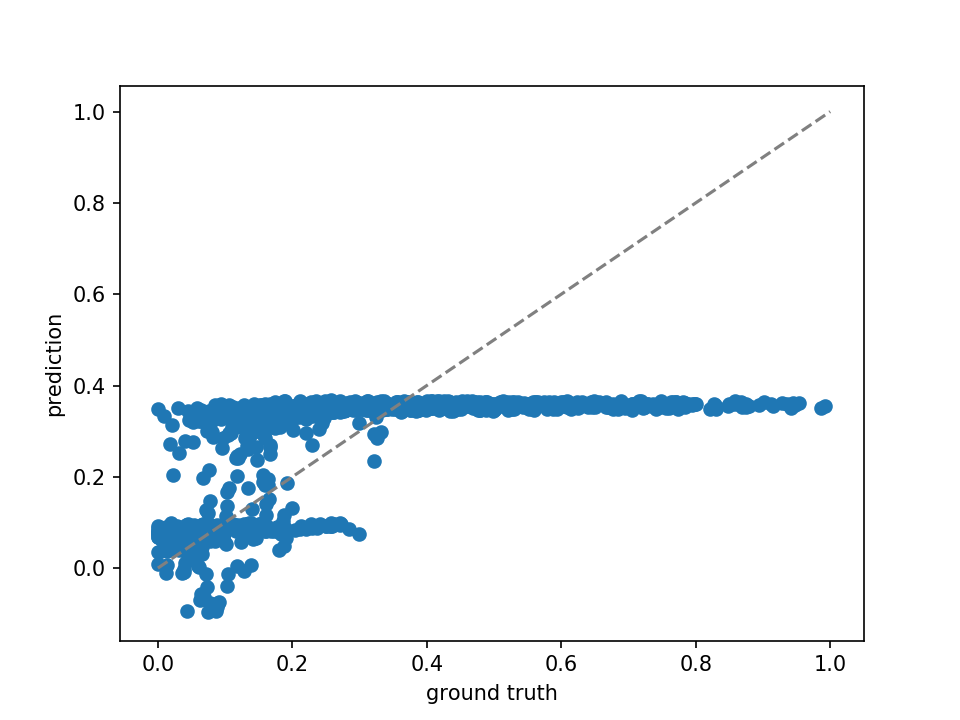

In [179]:
for count, degree in enumerate([2]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge(solver='svd'))
    model.fit(x_train, y_train)
    y_test_output = model.predict(x_test)
    accuracy = np.sum(y_test == y_test_output)
    print y_dev.shape, accuracy
    
    
    # evaluation
    plot_regress_viz(y_test, y_test_output)
#     r2_score_result(y_test, y_test_output)

In [180]:
np.sum((y_test < 0.1) == (y_test_output < 0.1))

973

In [181]:
np.sum((y_test < 0.1))

273

In [182]:
np.sum(np.logical_and((y_test_output < 0.1), (y_test < 0.1)))

223

In [183]:
np.sum(y_test_output < 0.1)

320

In [86]:
model = make_pipeline(PolynomialFeatures(degree), MLPRegressor(hidden_layer_sizes=(1000, 1000, 300, 200, 100), activation='relu', solver='adam', alpha=0.0001, verbose=True))
model.fit(x_train, y_train)
y_test_output = model.predict(x_test)
# plot_regress_viz(y_test, y_test_output)
print r2_score_result(y_test, y_test_output)

Iteration 1, loss = 0.01414442
Iteration 2, loss = 0.00819648
Iteration 3, loss = 0.00620626
Iteration 4, loss = 0.00575608
Iteration 5, loss = 0.00552190
Iteration 6, loss = 0.00485921
Iteration 7, loss = 0.00432388
Iteration 8, loss = 0.00463229
Iteration 9, loss = 0.00488325
Iteration 10, loss = 0.00397657
Iteration 11, loss = 0.00394192
Iteration 12, loss = 0.00413581
Iteration 13, loss = 0.00393094
Iteration 14, loss = 0.00332351
Iteration 15, loss = 0.00344757
Iteration 16, loss = 0.00441577
Iteration 17, loss = 0.00365260
Iteration 18, loss = 0.00371805
Iteration 19, loss = 0.00383813
Iteration 20, loss = 0.00397631
Iteration 21, loss = 0.00339576
Iteration 22, loss = 0.00355625
Iteration 23, loss = 0.00353630
Iteration 24, loss = 0.00358486
Iteration 25, loss = 0.00322235
Iteration 26, loss = 0.00326328
Iteration 27, loss = 0.00334008
Iteration 28, loss = 0.00362482
Iteration 29, loss = 0.00321320
Iteration 30, loss = 0.00394522
Iteration 31, loss = 0.00350234
Iteration 32, los

In [209]:
plot_regress_viz(y_test, y_test_output)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


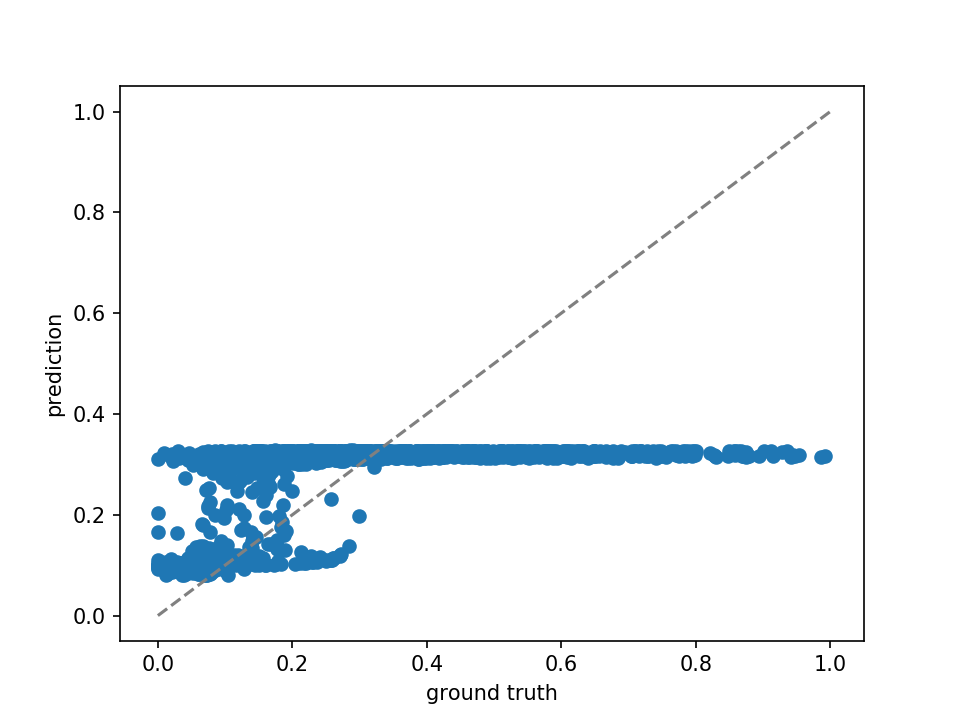

r2 score is 0.322183
0.3221834302428924


In [195]:
model = make_pipeline(SVR(kernel='rbf', gamma=0.01))
model.fit(x_train, y_train)
y_test_output = model.predict(x_test)
plot_regress_viz(y_test, y_test_output)
print r2_score_result(y_test, y_test_output)